### Import Packages

In [ ]:
import json
import string
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import torch 
import tensorflow as tf

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dropout, LSTM, CuDNNLSTM, Bidirectional, add
from keras.layers import Lambda, dot, Activation, concatenate
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.models import load_model


from gensim.models import Word2Vec, Phrases
from gensim.test.utils import common_texts

# using gpu
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

### Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

### Loading Files

In [ ]:
# labels
with open('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/labels.json') as json_file:
  labels_dic = json.load(json_file)

# labels_with_bbox
with open('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/labels_with_bbox.json') as json_file:
  labels_with_bbox_dic = json.load(json_file)

# images_info
with open('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/images_info.json') as json_file:
  images_info_dic = json.load(json_file)

# categories_info
with open('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/categories_info.json') as json_file:
  categories_info_dic = json.load(json_file)

# captions
with open('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/captions.json') as json_file:
  captions_dic = json.load(json_file)

# additional labels
with open('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/More/additional_labels.json') as json_file:
  additional_labels_dic = json.load(json_file)

# additional images info
with open('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/More/additional_images_info.json') as json_file:
  additional_images_info_dic = json.load(json_file)

# additional captions
with open('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/More/additional_captions.json') as json_file:
  additional_captions_dic = json.load(json_file)

labels_with_bbox_dic = labels_with_bbox_dic + additional_labels_dic
images_info_dic = images_info_dic + additional_images_info_dic
captions_dic = captions_dic + additional_captions_dic


del(additional_labels_dic)
del(additional_images_info_dic)
del(additional_captions_dic)

### Loading And Resizing Images

In [ ]:
# images_array = np.zeros((15000, 200, 200, 3), dtype=np.float32)

# images
with ZipFile('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/images.zip', 'r') as zipfile:
  infolist = zipfile.infolist()
  infolist = [infolist[i] for i in range(1, len(infolist)) if i%2==0]
  images_name = []
  for i, info in enumerate(infolist):
    images_name.append(info.filename[8:])
    # temp = Image.open(zipfile.open(info))
    # temp = temp.convert('RGB')
    # temp = temp.resize((200, 200))
    # temp = np.asarray(temp).astype('float32')
    # images_array[i] = temp

i += 1
# additional images
with ZipFile('drive/My Drive/Colab Notebooks/Deep Learning Project(1)/DeepLearning2019 - Project Data Set/More/MoreImages.zip', 'r') as zipfile:
  infolist2 = zipfile.infolist()[1:]
  add_images_name = []
  for j, info in enumerate(infolist2):
    add_images_name.append(info.filename[11:])
    # temp = Image.open(zipfile.open(info))
    # temp = temp.convert('RGB')
    # temp = temp.resize((200, 200))
    # temp = np.asarray(temp).astype('float32')
    # images_array[i+j] = temp

del(infolist)
del(infolist2)

images_name = images_name + add_images_name

del(add_images_name)

### Deleting Images Without Labels

In [ ]:
images_file_name = [index['file_name'] for index in images_info_dic]
image_id = [index['image_id'] for index in labels_with_bbox_dic]
for i, name in enumerate(images_name):
  id = images_info_dic[images_file_name.index(name)]['id']
  if id not in image_id:
    images_name.remove(name)
    # images_array = np.delete(images_array, i, 0)

del(images_file_name)
del(image_id)

### Min-Max Size of Images

In [ ]:
heights = [index['height'] for index in images_info_dic]
widths = [index['width'] for index in images_info_dic]

min_height = min(heights)
max_height = max(heights)
min_width = min(widths)
max_width = max(widths)


### Omitting Labels Without Images

In [ ]:
def omit_labels(our_list, omitting_labels, dic_key):
  j = 0
  for index in our_list:
    for k in range(len(omitting_labels)-1):
      if index[dic_key] > omitting_labels[k] and index[dic_key] < omitting_labels[k+1]:
        our_list[j][dic_key] += -(k+1)
        break
      if index[dic_key] > omitting_labels[9]:
        our_list[j][dic_key] += -10
        break
    j += 1
  return our_list


all_labels = [index['category_id'] for index in labels_with_bbox_dic]
omitting_labels = []
for i in range(1, 91):
  if i not in all_labels:
    omitting_labels.append(i)

# omitting labels
labels_with_bbox_dic = omit_labels(labels_with_bbox_dic, omitting_labels, 'category_id')
categories_info_dic = omit_labels(categories_info_dic, omitting_labels, 'id')

### Finding Image ID

In [ ]:
def get_id(name, images_info_dic):
  images_file_name = [index['file_name'] for index in images_info_dic]
  id = images_info_dic[images_file_name.index(name)]['id']
  return id

### Finding Image Labels

In [ ]:
def get_labels(id, labels_with_bbox_dic):
  labels_list = []
  for index in labels_with_bbox_dic:
    if index['image_id'] == id:
      labels_list.append(index['category_id'])
  return labels_list

### Targets of All Images

In [ ]:
all_targets = []
for name in images_name:
  id = get_id(name, images_info_dic)
  labels_list = get_labels(id, labels_with_bbox_dic)
  all_targets.append(labels_list)

### Generating One-Hot Targets

In [ ]:
num_classes = len(categories_info_dic)
num_images = len(images_array)
mlb = MultiLabelBinarizer()
targets_oh = mlb.fit_transform(all_targets).astype('float32')
del(all_targets)

### Saving Imprtant Data

In [ ]:
np.save('drive/My Drive/Colab Notebooks/images_array.npy', images_array)
np.save('drive/My Drive/Colab Notebooks/target_oh.npy', targets_oh)

### Loading Data

In [ ]:
num_classes = len(categories_info_dic)
images_array = np.load('drive/My Drive/Colab Notebooks/images_array.npy')
targets_oh = np.load('drive/My Drive/Colab Notebooks/target_oh.npy')

### CNN Model

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False,
                         input_shape=(200, 200, 3))

x = base_model.output

# adding a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# adding feature layer
features = Dense(1024, activation='relu')(x)

# prediction layer
predictions = Dense(num_classes, activation='sigmoid')(features)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()










Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________

### Preprocessing and Data Augmentation

In [ ]:
# inceptionv3 preprocess
images_array = preprocess_input(images_array)

# data augmentation
aug_data = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
    )
aug_data.fit(images_array[:13000])

### Training CNN(First Part)

In [ ]:
# freezing base model layers
for layer in base_model.layers:
  layer.trainable = False

# hyperparameters
learning_rate = 0.0005
batch_size = 64
epochs = 20

# optimizer
opt = optimizers.rmsprop(lr=learning_rate, decay=1e-6)

# compile
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# callback
file_path = 'drive/My Drive/Colab Notebooks/cp.top.best.hdf5'
mcp = ModelCheckpoint(file_path, monitor='val_acc', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='auto',
                      period=1)

history = model.fit_generator(aug_data.flow(images_array[:13000], targets_oh[:13000], batch_size=batch_size),
                    steps_per_epoch=images_array[:13000].shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[mcp],
                     validation_data=(images_array[13000:], targets_oh[13000:]))

Epoch 1/20
203/203 [==============================] - 115s 564ms/step - loss: 0.1280 - acc: 0.9636 - val_loss: 0.1226 - val_acc: 0.9682

Epoch 00001: val_acc improved from -inf to 0.96820, saving model to drive/My Drive/Colab Notebooks/cp.top.best.hdf5
Epoch 2/20
203/203 [==============================] - 112s 552ms/step - loss: 0.1049 - acc: 0.9680 - val_loss: 0.1173 - val_acc: 0.9687

Epoch 00002: val_acc improved from 0.96820 to 0.96870, saving model to drive/My Drive/Colab Notebooks/cp.top.best.hdf5
Epoch 3/20
203/203 [==============================] - 112s 550ms/step - loss: 0.1004 - acc: 0.9688 - val_loss: 0.1029 - val_acc: 0.9706

Epoch 00003: val_acc improved from 0.96870 to 0.97064, saving model to drive/My Drive/Colab Notebooks/cp.top.best.hdf5
Epoch 4/20
203/203 [==============================] - 111s 546ms/step - loss: 0.0975 - acc: 0.9693 - val_loss: 0.1091 - val_acc: 0.9688

Epoch 00004: val_acc did not improve from 0.97064
Epoch 5/20
203/203 [============================

### Training CNN(Second Part)

In [ ]:
# loading best model of last training part
model.load_weights('drive/My Drive/Colab Notebooks/cp.top.best.hdf5')

# unfreeze last 2 inception blocks
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# hyperparameters
learning_rate = 0.0001
batch_size = 64
epochs = 30

# optimizer
opt = optimizers.SGD(lr=learning_rate, momentum=0.9)

# compile
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# callback
file_path = 'drive/My Drive/Colab Notebooks/cp.fine_tuned.best.hdf5'
mcp2 = ModelCheckpoint(file_path, monitor='val_acc', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='auto',
                      period=1)

history = model.fit_generator(aug_data.flow(images_array[:13000], targets_oh[:13000], batch_size=batch_size),
                    steps_per_epoch=images_array[:13000].shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[mcp2],
                     validation_data=(images_array[13000:], targets_oh[13000:]))

Epoch 1/30
203/203 [==============================] - 114s 560ms/step - loss: 0.0928 - acc: 0.9702 - val_loss: 0.1110 - val_acc: 0.9725

Epoch 00001: val_acc improved from -inf to 0.97250, saving model to drive/My Drive/Colab Notebooks/cp.fine_tuned.best.hdf5
Epoch 2/30
203/203 [==============================] - 111s 549ms/step - loss: 0.0927 - acc: 0.9702 - val_loss: 0.1102 - val_acc: 0.9725

Epoch 00002: val_acc did not improve from 0.97250
Epoch 3/30
203/203 [==============================] - 109s 539ms/step - loss: 0.0923 - acc: 0.9703 - val_loss: 0.1095 - val_acc: 0.9725

Epoch 00003: val_acc did not improve from 0.97250
Epoch 4/30
203/203 [==============================] - 110s 541ms/step - loss: 0.0919 - acc: 0.9704 - val_loss: 0.1089 - val_acc: 0.9724

Epoch 00004: val_acc did not improve from 0.97250
Epoch 5/30
203/203 [==============================] - 109s 535ms/step - loss: 0.0916 - acc: 0.9705 - val_loss: 0.1082 - val_acc: 0.9724

Epoch 00005: val_acc did not improve from 

### Extracting Features

In [ ]:
# extracting features
layer_name = 'dense_1'
feature_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
features_array = feature_layer_model.predict(images_array)

### Saving Features

In [ ]:
np.save('drive/My Drive/Colab Notebooks/features_array.npy', features_array)

In [ ]:
features_array = np.load('drive/My Drive/Colab Notebooks/features_array.npy')

In [ ]:
features_array.shape

(14867, 2048)

### Generating Train and Test Dictionary of Caption

In [ ]:
train_captions = dict()
test_captions = dict()
sorted_captions = dict()
for j, name in enumerate(images_name):
  id = get_id(name, images_info_dic)
  cap_list = []
  for i, index in enumerate(captions_dic):
    if index['image_id'] == id:
      cap_list.append(captions_dic[i]['caption'])

  sorted_captions[id] = cap_list    
  if j < 7000:
    train_captions[id] = cap_list
  if j > 14000:
    test_captions[id] = cap_list

In [ ]:
with open('drive/My Drive/Colab Notebooks/train_captions.json', 'w') as f:
    json.dump(train_captions, f)

### Cleaning Captions

In [ ]:
# translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)

for key, cap_list in sorted_captions.items():
  for i in range(len(cap_list)):
    cap = cap_list[i]
    
    # split words
    cap = cap.split()

    # convert to lower case
    cap = [word.lower() for word in cap]

    # removing punctuations like '.' , ':', '&', '%', ...
    cap = [word.translate(table) for word in cap]

    # removing one letter characters like 'a'
    cap = [word for word in cap if len(word)>1]

    # removing words with numbers
    cap = [word for word in cap if word.isalpha()]

    # joining the words
    cap_list[i] =  ' '.join(cap) 

### All Captions

In [ ]:
all_train_captions = []
for key, value in train_captions.items():
  for cap in value:
    all_train_captions.append(cap)
  
all_test_captions = []
for key, value in test_captions.items():
  for cap in value:
    all_test_captions.append(cap)

all_captions = []
for key, value in sorted_captions.items():
  for cap in value:
    all_captions.append(cap)

### Maximum Length of Samples

In [ ]:
temp = [index.split(' ') for index in all_train_captions]
lengths = [len(index) for index in temp]
max_length = max(lengths)
del(temp)

### Adding PAD, START and END

In [ ]:
for key, cap_list in sorted_captions.items():
  for i in range(len(cap_list)):
    cap = cap_list[i]
    
    # split words
    cap = cap.split()
    cap_length = len(cap)

    cap_list[i] =  '<startseq> ' + ' '.join(cap) + ' <PAD>' * (max_length - cap_length) + ' <endseq>'

### New Maximum Length

In [ ]:
all_train_captions = []
for key, value in train_captions.items():
  for cap in value:
    all_train_captions.append(cap)

temp = [index.split(' ') for index in all_train_captions]
lengths = [len(index) for index in temp]
max_length = max(lengths)
del(temp)

### Vocabulary

In [ ]:
threshold = 5
word_counts = {}

for cap in all_train_captions:
  for word in cap.split(' '):
    word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
# vocab.append('<PAD>')
# vocab.append('<startseq>')
# vocab.append('<endseq>')

# set numbers to words
vocab_to_int = { ch:i for i,ch in enumerate(vocab) }
int_to_vocab = { i:ch for i,ch in enumerate(vocab) }

### ID and Features Dictionary

In [ ]:
featureID_dic = {}
for i, name in enumerate(images_name):
  id = get_id(name, images_info_dic)
  featureID_dic[id] = features_array[i]

### Word2Vec

In [ ]:
embedding_dim = 200
corpus = [index.split(' ') for index in all_train_captions]

# CBOW word2vec
word_model = Word2Vec(corpus, min_count=threshold, size=embedding_dim)

### Data Generator

In [ ]:
def data_generator(captions, featureID, wordtoint, max_length,
                   num_photos_per_batch, vocab_size):
    X1, X2, y = list(), list(), list()
    num_samples = 0
    while 1:
        for key, cap_list in captions.items():
            num_samples += 1
            feature = featureID[key]

            for cap in cap_list:
    
                int_seq = [wordtoint[word] for word in cap.split(' ') if word in wordtoint]
                word_seq = [word for word in cap.split(' ') if word in wordtoint]

                length = len(word_seq)
                if length != max_length:
                  word_seq = word_seq[:-1]
                  int_seq = int_seq[:-1]
                  for k in range(max_length - length):
                    int_seq.append(wordtoint['<PAD>'])
                    word_seq.append('<PAD>')
                  word_seq.append('<endseq>')  
                  int_seq.append(wordtoint['<PAD>'])
                

                pre_in_seq, out_seq = word_seq, int_seq

                in_seq = []
                
                for w in pre_in_seq:
                  in_seq.append(word_model[w])
                

                out_seq = in_seq[1:]
                in_seq = in_seq[:-1]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)
            
            if num_samples == num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                num_samples = 0

### Attention

In [ ]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
    
    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'step_dim': self.step_dim,
                       'W_regularizer': self.W_regularizer,
                       'b_regularizer': self.b_regularizer,
                       'W_constraint': self.W_constraint,
                       'b_constraint': self.b_constraint,
                       'bias': self.bias})
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

### RNN Model

In [ ]:
# feature input layer
feature_input = Input(shape=(2048,))
feature_after_drop = Dropout(0.5)(feature_input)
batch_out = BatchNormalization()(feature_after_drop)
dense_out = Dense(256, activation='relu')(batch_out)

# sequence input layer
sequence_input = Input(shape=(max_length-1, embedding_dim))
sequence_after_drop = Dropout(0.5)(sequence_input)
lstm_out = Bidirectional(CuDNNLSTM(128, return_sequences=True))(sequence_after_drop)
# lstm_out = Attention(max_length)(lstm_out)

# feed forward model
decoder1 = add([dense_out, lstm_out])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = BatchNormalization()(decoder2)
output = Dense(embedding_dim, activation='linear')(decoder3)


RNN_model = Model(inputs=[feature_input, sequence_input], outputs=output)

RNN_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 46, 200)      0                                            
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 2048)         8192        dropout_5[0][0]                  
____________________________________________________________________________________________

### Plotting Model

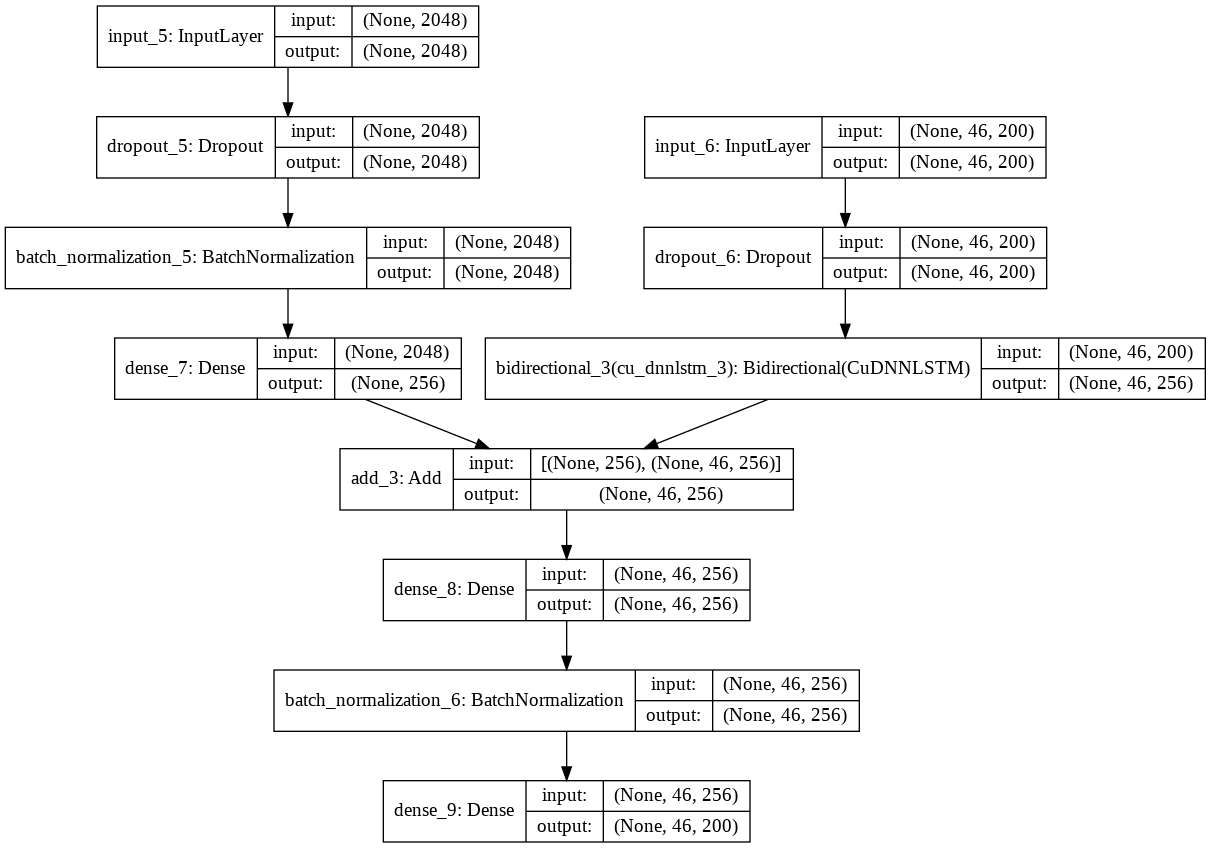

In [ ]:
plot_model(RNN_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
i = 0
small_set = dict()
for key, value in train_captions.items():
  if i < 7000:
    small_set[key] = value
  i += 1

In [ ]:
all_small_captions = []
for key, value in small_set.items():
  for cap in value:
    all_small_captions.append(cap)

### Training RNN

In [ ]:
# optimizer
opt = optimizers.rmsprop(lr=0.001)

# compile
RNN_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

# hyperparameters
batch_size = 32
epochs = 20
train_steps = len(all_train_captions)//batch_size
test_steps = len(all_test_captions)//batch_size

# generator
train_generator = data_generator(train_captions, featureID_dic, vocab_to_int,
                           max_length, batch_size, len(vocab_to_int))
test_generator = data_generator(test_captions, featureID_dic, vocab_to_int,
                           max_length, batch_size, len(vocab_to_int))

# training
history = RNN_model.fit_generator(train_generator, epochs=epochs,
                                  steps_per_epoch=train_steps, verbose=1,
                                  validation_data=test_generator,
                                  validation_steps=test_steps)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


2188/2188 [==============================] - 101s 46ms/step - loss: 0.0402 - acc: 0.8629 - val_loss: 0.0926 - val_acc: 0.8944
Epoch 2/20
2188/2188 [==============================] - 98s 45ms/step - loss: 0.0123 - acc: 0.9074 - val_loss: 0.0698 - val_acc: 0.9242
Epoch 3/20
2188/2188 [==============================] - 96s 44ms/step - loss: 0.0082 - acc: 0.9194 - val_loss: 0.0576 - val_acc: 0.9207
Epoch 4/20
2188/2188 [==============================] - 96s 44ms/step - loss: 0.0062 - acc: 0.9250 - val_loss: 0.0465 - val_acc: 0.9395
Epoch 5/20
2188/2188 [==============================] - 96s 44ms/step - loss: 0.0051 - acc: 0.9297 - val_loss: 0.0528 - val_acc: 0.9336
Epoch 6/20
2188/2188 [==============================] - 96s 44ms/step - loss: 0.0044 - acc: 0.9337 - val_loss: 0.0561 - val_acc: 0.9502
Epoch 7/20
2188/2188 [==============================] - 95s 43ms/step - loss: 0.0038 - acc: 0.9367 - val_loss: 0.0643 - val_acc: 0.9442
Epoch 8/20
2188/2188 [==============================] - 96

In [ ]:
RNN_model.save('drive/My Drive/Colab Notebooks/RNN_model2_20_0.001_mm.h5')

In [ ]:
RNN_model = load_model('drive/My Drive/Colab Notebooks/RNN_model2_20_0.001_mm.h5')

### Inference(Generating Captions)

In [ ]:
def Inference(feature, max_length, wordtoint, inttoword):
    in_text = '<startseq>'
    for i in range(max_length-1):
        sequence = [word_model[word] for word in in_text.split() if word in wordtoint]

        length = len(sequence)
        for k in range(max_length - length - 1):
          sequence.append(word_model['<PAD>'])
        
        in_seq = np.expand_dims(np.array(sequence), axis=0)
        output = RNN_model.predict([feature, in_seq], verbose=0)[0, i, :]
        output = word_model.most_similar(positive=[output],topn=1)[0][0]
        in_text += ' ' + output
        if word == '<endseq>':
            break
    final = in_text.split()
    # final = final[1:-1]
    final = ' '.join(final)
    return final

print(Inference(np.expand_dims(features_array[0], axis=0), max_length, vocab_to_int, int_to_vocab))
plt.imshow(images_array[0]/255.)
plt.show()